## Facial Expression Classifier - Final Submission

0 = Angry //
1 = Disgust //
2 = Fear //
3 = Happy //
4 = Sad //
5 = Surpise //
6 = Neutral

In [87]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import os
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import h5py
from keras.preprocessing.image import ImageDataGenerator

In [88]:
# Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [89]:
# For VGG16 transfer learning
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [91]:
# Function to convert csv file to images - got help from Kaggle (https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion/29428)
def main():
    if len(sys.argv) < 2:
        print('Usage: python cv_to_img.py [output_path]')
        return -1

    output_path = sys.argv[1]

    if os.path.exists(output_path):

        os.system('rm -rf {}'.format(output_path))

    os.system('mkdir {}'.format(output_path))

    label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    #data = pd.read_csv('fer2013.csv', delimiter=',')
    data = np.genfromtxt('fer2013.csv',delimiter=',',dtype=None, encoding='utf8')

    labels = data[1:,0].astype(np.int32)
    image_buffer = data[1:,1]
    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in image_buffer])
    usage = data[1:,2]
    dataset = zip(labels, images, usage)
    for i, d in enumerate(dataset):
        usage_path = os.path.join(output_path, d[-1])
        label_path = os.path.join(usage_path, label_names[d[0]])
        img = d[1].reshape((48,48))
        img_name = '%08d.jpg' % i
        img_path = os.path.join(label_path, img_name)
        if not os.path.exists(usage_path):
            os.system('mkdir {}'.format(usage_path))
        if not os.path.exists(label_path):
            os.system('mkdir {}'.format(label_path))
        cv2.imwrite(img_path, img)
        print('Write {}'.format(img_path))

In [92]:
# Run the main function - running this will create 35,000 images
# main()

In [93]:
# Generate data from text
data = np.genfromtxt('fer2013.csv', delimiter=',', dtype=None, encoding='utf8')

In [94]:
data.shape

(35888, 3)

In [95]:
# Convert data to DataFrame
data = data[1:,:]
fer_df = pd.DataFrame(data)

In [96]:
# Drop non-usable images (inspected manually)
to_drop = [5439,6458,7496,11286,12352,13148,13402,15894,20222,20817,22198,24441,\
28601,9679,59,5274,7527,9026,9500,14279,4275,7172,7629,8030,8737,8856,11244,15838,\
16540,26383,2171,6102,11846,12289,15144,17081,19632,21817,22927,26897,10423,11295,\
2059,2809,3262,5722,13988,19238,20712,30002,29447,29557,32662,35743,32683,35632,35121]

In [97]:
# How many invalid images
len(to_drop)

57

In [98]:
# Drop invalid images, reset index
fer_df.drop(to_drop, axis=0, inplace=True)
fer_df.reset_index(drop=True, inplace=True)

In [99]:
# Make pickle files of training, test1, test2
training_df = fer_df[fer_df[2] == 'Training'].copy()
pub_test_df = fer_df[fer_df[2] == 'PublicTest'].copy()
priv_test_df = fer_df[fer_df[2] == 'PrivateTest'].copy()
training_df.to_pickle("./training_df")
pub_test_df.to_pickle("./pub_test_df")
priv_test_df.to_pickle("./priv_test_df")

In [100]:
# Read training pickle file
training_all_df = pd.read_pickle("./training_df")
training_all_df.head()

,0,1,2
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [101]:
training_all_df.shape

(28660, 3)

In [102]:
# Isolate five expressions to focus on
training_five_df = training_all_df[training_all_df[0].isin(['0','3','4','5','6'])].copy()
training_five_df[0] = training_five_df[0].astype(int)

In [103]:
# Map five expressions
new_map = {0:0,3:1,4:2,5:3,6:4}
training_five_df[0] = training_five_df[0].map(new_map)
training_five_df.head()

,0,1,2
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training


In [104]:
# Split from strings to individual columns
training_five_pixels_df = training_five_df[1].copy()
training_five_pixels_df = training_five_pixels_df.str.split(pat=' ', expand=True).copy()
training_five_pixels_df = training_five_pixels_df.astype('float').copy()
training_five_pixels_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,70.0,80.0,82.0,72.0,58.0,58.0,60.0,63.0,54.0,58.0,...,159.0,182.0,183.0,136.0,106.0,116.0,95.0,106.0,109.0,82.0
1,151.0,150.0,147.0,155.0,148.0,133.0,111.0,140.0,170.0,174.0,...,105.0,108.0,95.0,108.0,102.0,67.0,171.0,193.0,183.0,184.0
3,24.0,32.0,36.0,30.0,32.0,23.0,19.0,20.0,30.0,41.0,...,174.0,126.0,132.0,132.0,133.0,136.0,139.0,142.0,143.0,142.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,34.0,31.0,31.0,31.0,27.0,31.0,30.0,29.0,30.0
6,20.0,17.0,19.0,21.0,25.0,38.0,42.0,42.0,46.0,54.0,...,29.0,36.0,68.0,91.0,85.0,93.0,97.0,99.0,107.0,118.0


In [105]:
training_five_pixels_df.shape

(24134, 2304)

In [106]:
# Obtain X_train, y_train
X_train = training_five_pixels_df.copy()
y_train = training_five_df[0].astype('int32')

In [107]:
# Pre-process the X_test and y_test
pub_test_all_df = pd.read_pickle("./pub_test_df")
pub_test_five_df = pub_test_all_df[pub_test_all_df[0].isin(['0','3','4','5','6'])].copy()
pub_test_five_df[0] = pub_test_five_df[0].astype(int)

In [108]:
# Map test data
pub_test_five_df[0] = pub_test_five_df[0].map(new_map)

In [109]:
# Obtain X_test, y_test
pub_test_five_pixels_df = pub_test_five_df[1].copy()
pub_test_five_pixels_df = pub_test_five_pixels_df.str.split(pat=' ', expand=True).copy()
pub_test_five_pixels_df = pub_test_five_pixels_df.astype('float').copy()
X_test = pub_test_five_pixels_df.copy()
y_test = pub_test_five_df[0].astype('int32')

In [110]:
X_test.shape

(3034, 2304)

In [111]:
# Run LogisticRegression - takes a long time.  Model is included, skip to next cell to load model.
# Experimentally found to show best accuracy in a reasonable time - Without PCA
# five_model = LogisticRegression(solver='saga', penalty='l2', C=0.0001, max_iter=1000, random_state=1)
# five_model.fit(X_train, y_train)

In [112]:
# Import model created using 5 expressions and flattened pixels
from joblib import dump, load
five_model = load('five/five_model_logit.joblib')

In [113]:
print("Train Set Score: ", five_model.score(X_train, y_train))
print("Test Set Score: ", five_model.score(X_test, y_test))

Train Set Score:  0.5457445926908097
Test Set Score:  0.39650626235992087


In [114]:
# Store model created using 2 expressions and flattened pixels
# from joblib import dump, load
# dump(five_model, 'five/five_model_logit.joblib')

In [115]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
# Implement the PCA with 500 components
pca3 = PCA(n_components=500)
pca3.fit(X_train_scaled)

# Transform the data
X_train_scaled_pca = pca3.transform(X_train_scaled)
X_test_scaled_pca = pca3.transform(X_test_scaled)

In [117]:
# Re-run the logit using the PCA reduced data
# This runs quite fast
five_model_pca = LogisticRegression(solver='saga', penalty='l2', C=0.0001, max_iter=1000, random_state=1)
five_model_pca.fit(X_train_scaled_pca, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
# Check scores using PCA
print("Train Set Score (PCA): ", five_model_pca.score(X_train_scaled_pca, y_train))
print("Test Set Score (PCA): ", five_model_pca.score(X_test_scaled_pca, y_test))

Train Set Score (PCA):  0.4550426783790503
Test Set Score (PCA):  0.45088991430454844


In [119]:
# Store all data as pickle files - used in multiple notebooks / sessions
X_train.to_pickle('five/X_train')
y_train.to_pickle('five/y_train')
X_test.to_pickle('five/X_test')
y_test.to_pickle('five/y_test')

In [120]:
# Read all data as pickle files - used in multiple notebooks / sessions
X_train = pd.read_pickle("five/X_train")
y_train = pd.read_pickle("five/y_train")
X_test = pd.read_pickle("five/X_test")
y_test = pd.read_pickle("five/y_test")

In [121]:
# Convert to numpy
X_train = X_train.to_numpy()
X_train = X_train.reshape(24134, 48, 48)
X_train.shape

(24134, 48, 48)

In [122]:
# Convert to numpy
X_test = X_test.to_numpy()
X_test = X_test.reshape(3034, 48, 48)
X_test.shape

(3034, 48, 48)

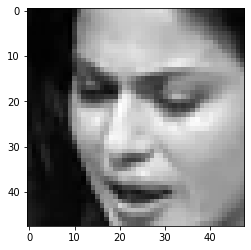

In [123]:
# Test one image
plt.imshow(X_test[257], cmap='gray')

In [124]:
# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (24134, 48, 48)
y_train shape: (24134,)
X_test shape: (3034, 48, 48)
y_test shape: (3034,)


In [125]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')
# y unique values
print(f'y values: {np.unique(y_train)}')
num_classes = len(np.unique(y_train))
print(f'Number of classes: {num_classes}')

X range: 0.0-255.0
y values: [0 1 2 3 4]
Number of classes: 5


In [126]:
# Define input image dimensions
img_rows, img_cols = 48, 48

# Reshape for Keras model types
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (24134, 48, 48, 1)
X_test shape: (3034, 48, 48, 1)


In [127]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [128]:
# Create image augmentation generator
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

In [129]:
# Create a simple CNN model - based on the example in class
# This example uses pooling for dimensionality reduction and Dropout to reduce overfitting
fer_CNN_model_1 = Sequential()

fer_CNN_model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
fer_CNN_model_1.add(Conv2D(64, (3, 3), activation='relu'))
fer_CNN_model_1.add(MaxPooling2D(pool_size=(2,2)))

fer_CNN_model_1.add(Dropout(0.25))
fer_CNN_model_1.add(Flatten())
fer_CNN_model_1.add(Dense(128, activation='relu'))
fer_CNN_model_1.add(Dropout(0.5))
fer_CNN_model_1.add(Dense(num_classes, activation='softmax'))

fer_CNN_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3965056   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [130]:
# Compile the model using the sparse_categorical_crossentropy, optimizer, and metric
fer_CNN_model_1.compile(loss='sparse_categorical_crossentropy',
                        optimizer = 'Adam',
                        metrics = ['accuracy'])

In [131]:
# Fit the model on the training data, defining the batch_size, epochs, and test data
# This will take a long time
# Skip to "Load Saved Model" to load
# history = fer_CNN_model_1.fit(X_train, y_train,
#                     batch_size=32,
#                     epochs=14,
#                     verbose=1,
#                     validation_data = (X_test, y_test))

# Attempt at using real-time data augmentation
# fer_CNN_model_1.fit(aug.flow(X_train, y_train, batch_size=32),
#                     steps_per_epoch=len(X_train)/32, epochs=12)

In [132]:
# Won't run unless trained the model
# plt.figure()
# plt.plot(history.history['val_loss'], marker='o', label='loss')
# plt.plot(history.history['val_acc'], marker='o', label='accuracy')
# plt.title('Validation Accuracy and Loss')
# plt.legend(loc='best')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy / Loss')
# plt.savefig('Val.png')
# plt.show()

In [133]:
# Won't run unless trained the model
# plt.figure()
# plt.plot(history.history['loss'], marker='o', label='loss')
# plt.plot(history.history['acc'], marker='o', label='accuracy')
# plt.title('Training Accuracy and Loss')
# plt.legend(loc='best')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy / Loss')
# plt.savefig('train.png')
# plt.show()

In [134]:
# Save the model for future use
# fer_CNN_model_1.save("five/CNN_model_five_3.h5")
# print("Saved model to disk")

In [135]:
# Load saved model
from tensorflow.keras.models import load_model
fer_CNN_model_4 = load_model("five/CNN_model_five_2.h5")

In [136]:
# Evaluate the model's performance on the test data
score = fer_CNN_model_4.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

3034/3034 [==============================] - 3s 1ms/sample - loss: 1.2857 - acc: 0.5959
Test loss: 1.2857239211792213
Test accuracy: 0.595913


In [137]:
# Make predictions
y_pred = fer_CNN_model_4.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['prediction'] = y_pred_df.idxmax(axis=1)
cm = confusion_matrix(y_test, y_pred_df['prediction'])

In [138]:
# Build confusion matrix
cm_df = pd.DataFrame(cm, index=['True Angry','True Happy','True Sad','True Surprise','True Neutral'], 
                     columns=['Pred. Angry','Pred. Happy','Pred. Sad','Pred. Surprise','Pred. Neutral'])
cm_df

,Pred. Angry,Pred. Happy,Pred. Sad,Pred. Surprise,Pred. Neutral
True Angry,196,65,103,25,77
True Happy,42,659,76,28,89
True Sad,92,75,329,23,134
True Surprise,23,33,22,316,20
True Neutral,57,79,142,21,308


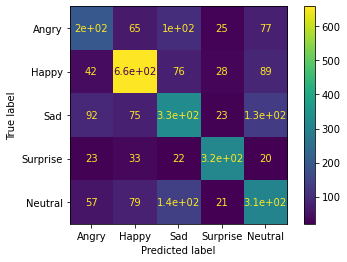

In [139]:
# Display confusion Matrix
ConfusionMatrixDisplay(cm, display_labels=['Angry','Happy','Sad','Surprise','Neutral']).plot()

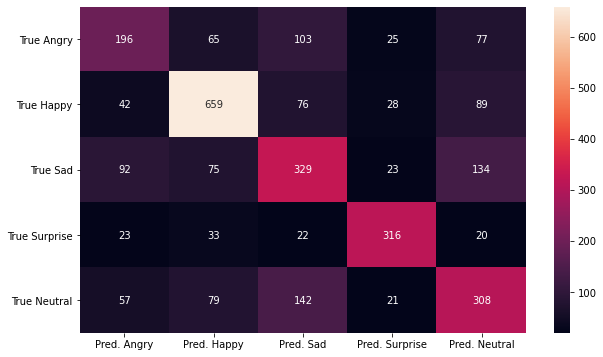

In [140]:
# Display confusion matrix in seaborn
import seaborn as sns
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm_df, annot=True, fmt='g')
plt.savefig("cm.png")
plt.show()

In [141]:
# Import the pretrained VGG16 model and do not include the final layer:
base_model = VGG16(weights='imagenet', include_top=False)

In [142]:
# Assign the output of this base_model to a variable:
base_model_out = base_model.output

# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(243, activation='relu')(base_model_out) 
base_model_out = Dense(243, activation='relu')(base_model_out)
base_model_out = Dense(81, activation='relu')(base_model_out)

# Add a final layer with 5 neurons, one for each class in our dataset 
# using a softmabase_model_out activation function:
preds = Dense(5, activation='softmax')(base_model_out)

# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = base_model.input, 
              outputs = preds)

In [143]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_8
21 dense_9
22 dense_10
23 dense_11


In [144]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [145]:
for layer in model.layers[:20]:
    layer.trainable=False
    
for layer in model.layers[20:]:
    layer.trainable=True

In [146]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

In [147]:
# This will only work with the data directories
# Set the train_generator with settings
train_generator = train_datagen.flow_from_directory('five/data/Training', # path to the training data folder
                                                 target_size=(48,48),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 24176 images belonging to 5 classes.


In [148]:
# Combile model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [149]:
# Set step size
step_size_train = train_generator.n//train_generator.batch_size

In [150]:
# Fit model - this takes a long time
# Skip to load_model
# history = model.fit_generator(generator = train_generator, 
#                     steps_per_epoch = step_size_train, 
#                     epochs = 10)

In [151]:
# import h5py
# model.save("five/vgg16_five_2.h5")
# print("Saved model to disk")

In [152]:
# better to load the model
import h5py
model = load_model("five/vgg16_five_2.h5")

In [153]:
# Plot the loss and accuracy
# Won't work unless you trained the model
# plt.figure()
# plt.plot(history.history['loss'], marker='o', label='loss')
# plt.plot(history.history['acc'], marker='o', label='accuracy')
# plt.title('Training Accuracy and Loss')
# plt.legend(loc='best')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy / Loss')
# plt.show()

In [154]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [155]:
# Create test generator - specify path to test data
test_generator = test_datagen.flow_from_directory('five/data/PrivateTest', # path to the training data folder
                                                 target_size=(48,48),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 3006 images belonging to 5 classes.


In [156]:
# Make prediction
prediction = model.predict_generator(test_generator, steps = 1)
prediction

array([[7.5456399e-01, 2.1876459e-01, 2.6615117e-02, 5.6203669e-05,
        5.1471477e-10],
       [1.0000000e+00, 7.0065470e-32, 0.0000000e+00, 1.9221247e-22,
        7.1846162e-24],
       [2.6868705e-14, 1.6880001e-11, 2.2044237e-08, 1.0000000e+00,
        2.6427551e-09],
       ...,
       [2.6290104e-01, 7.2963673e-01, 2.1287965e-06, 3.2027655e-03,
        4.2573842e-03],
       [3.6604517e-05, 3.3049703e-06, 1.2481188e-02, 2.3349527e-04,
        9.8724538e-01],
       [2.4911921e-04, 9.2828674e-07, 2.1341739e-05, 3.0756983e-04,
        9.9942112e-01]], dtype=float32)

In [157]:
# Get predictions
test_true = test_generator.classes
test_pred = prediction.argmax(axis=1)

In [158]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(test_true,test_pred),
            index = ['true Angry','true Happy','true Sad','true Surprise', 'true Neutral'],
            columns =  ['predicted Angry','predicted Happy','predicted Sad','true Surprise','true Neutral'])

,predicted Angry,predicted Happy,predicted Sad,true Surprise,true Neutral
true Angry,161,75,84,125,46
true Happy,74,476,147,125,57
true Sad,61,105,317,106,37
true Surprise,78,93,143,247,33
true Neutral,22,29,43,29,293


In [159]:
# Get accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(test_true,test_pred)

0.49700598802395207

In [160]:
# Import haar cascade classifier to crop faces
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

img = cv2.imread('examples/neutral4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [161]:
# Import model from before
from tensorflow.keras.models import load_model
model = load_model("five/CNN_model_five_2.h5")

In [162]:
# helper method for UI
def prep_model(image):
    image = rgb2gray(image)
    image = cv2.resize(image, (48,48))
    image = image.reshape(1,48,48,1)
    image = image.astype('float32')
    image /= 255
    return image

In [163]:
# helper method for UI - convert to grayscale
import numpy as np

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [164]:
# Function for getting a prediction based on any image with a face in it
def read_prep_model(path, model):
    # set up haar classifier
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    x = faces[0][0]
    y = faces[0][1]
    w = faces[0][2]
    h = faces[0][3]
    
    img_cropped = cv2.imread(path)[y:y+h,x:x+w]
    image = prep_model(img_cropped)
    scores = model.predict(image)
    scores_int = np.rint(scores*100).astype(int).reshape(5,)
    angry_score = scores_int[0]
    happy_score = scores_int[1]
    sad_score = scores_int[2]
    surprise_score = scores_int[3]
    neutral_score = scores_int[4]
    
    display_str = f'''Facial Expression Probabilities\nfor {path}:
    
    Angry:     {angry_score}%
    Happy:     {happy_score}%
    Sad:       {sad_score}%
    Surprise:  {surprise_score}%
    Neutral:   {neutral_score}%
    '''
    return display_str

In [165]:
# Example usage - Set path to an image
path = "examples_1/4.jpg"
print(read_prep_model(path, model))

Facial Expression Probabilities
for examples_1/4.jpg:
    
    Angry:     0%
    Happy:     93%
    Sad:       0%
    Surprise:  6%
    Neutral:   1%
    
